In [1]:
import os
os.getcwd()

os.chdir("./src")

In [27]:
from diffusion_model_discrete import DiscreteDenoisingDiffusion
from new_functions import mol_to_data, is_valid_molecule
import torch

model = DiscreteDenoisingDiffusion.load_from_checkpoint("./outputs/checkpoint_moses.ckpt", map_location=torch.device('cuda'))

Lightning automatically upgraded your loaded checkpoint from v1.6.5 to v2.3.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint outputs/checkpoint_moses.ckpt`


Marginal distribution of the classes: tensor([0.5664, 0.1071, 0.1283, 0.0812, 0.1115, 0.0042, 0.0012, 0.0000],
       device='cuda:0') for nodes, tensor([8.4956e-01, 4.4773e-02, 5.9329e-02, 3.3361e-04, 4.6009e-02],
       device='cuda:0') for edges


/home/kkladny/anaconda3/envs/digress/lib/python3.9/site-packages/torch/nn/init.py:452: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/home/kkladny/anaconda3/envs/digress/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'train_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['train_metrics'])`.
/home/kkladny/anaconda3/envs/digress/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'sampling_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['sampling_metrics'])`.


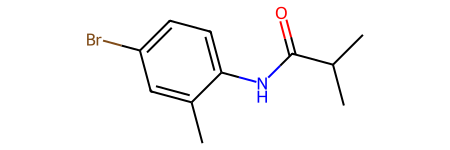

In [3]:
import moses

test_smile = 'Cc1cc(Br)ccc1NC(=O)C(C)C'
# plot the test molecule
from rdkit import Chem
from rdkit.Chem import Draw
mol = Chem.MolFromSmiles(test_smile)
mol

In [28]:
mol.GetNumAtoms()
mol_data = mol_to_data(mol)
mol_data

(tensor([[0, 0, 0, 0, 6, 0, 0, 0, 1, 0, 3, 0, 0, 0]]),
 tensor([[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 0, 4, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0],
          [0, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 4, 0, 1, 4, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 0, 0, 0, 0],
          [0, 4, 0, 0, 0, 0, 4, 0, 1, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]]]))

In [4]:
from analysis.visualization import MolecularVisualization
from datasets.moses_dataset import MOSESinfos, MOSESDataModule
from hydra import compose, initialize
from omegaconf import OmegaConf
from rdkit import Chem

with initialize(version_base=None, config_path="configs"):
    cfg = compose(config_name="config")

datamodule = MOSESDataModule(cfg=cfg)
#datamodule.prepare_data()
infos = MOSESinfos(datamodule=datamodule)
vis = MolecularVisualization(remove_h=True, dataset_infos=infos)

In [5]:
#samples = model.sample_batch(batch_id=1, batch_size=1024, keep_chain=4, number_chain_steps=4, save_final=4, num_nodes=14)
#example = model.sample_batch(batch_id=1, batch_size=1, keep_chain=4, number_chain_steps=4, save_final=4, num_nodes=16)

In [5]:
#example_mol = vis.mol_from_graphs(example[0][0], example[0][1])
from rdkit.Chem.Scaffolds import MurckoScaffold

scaffold = MurckoScaffold.GetScaffoldForMol(mol)
Chem.MolToSmiles(scaffold)

'c1ccccc1'

In [6]:
from new_functions import mol_to_data, is_valid_molecule
# turn scaffold into a data
data = mol_to_data(scaffold)

In [7]:
data[1][0]

tensor([[0, 4, 0, 0, 0, 4],
        [4, 0, 4, 0, 0, 0],
        [0, 4, 0, 4, 0, 0],
        [0, 0, 4, 0, 4, 0],
        [0, 0, 0, 4, 0, 4],
        [4, 0, 0, 0, 4, 0]])

In [48]:
example_2 = model.sample_batch(batch_id=1, batch_size=64, keep_chain=1, number_chain_steps=1, save_final=1, num_nodes=14, scaffold_mask=(mol_data[0][0][:13], mol_data[1][0][:13, :13]))

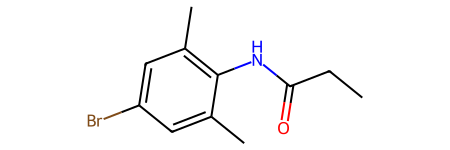

In [62]:
example_2_mol = vis.mol_from_graphs(example_2[7][0], example_2[7][1])
example_2_mol

In [52]:
# compute similarities between mol and example_2
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs

mol_gens = [vis.mol_from_graphs(mol_gen[0], mol_gen[1]) for mol_gen in example_2]
valid_mol_gens = [mol_gen for mol_gen in mol_gens if is_valid_molecule(mol_gen)]
fps = [AllChem.GetMorganFingerprintAsBitVect(mol_gen, 1) for mol_gen in valid_mol_gens]

Sanitization error: Explicit valence for atom # 4 Br, 4, is greater than permitted


[17:25:31] Explicit valence for atom # 4 Br, 4, is greater than permitted


In [57]:
# compute similarities to original molecule
fps_mol = AllChem.GetMorganFingerprintAsBitVect(mol, 1)
similarities = [DataStructs.TanimotoSimilarity(fps_mol, fp, 2) for fp in fps]
max(similarities)

0.8285714285714285

In [13]:
example_2_mod = example_2
example_2_mod[0][0][5:] = example_X
example_2_mod[0][1][5:, 5:] = example_E

NameError: name 'example_X' is not defined

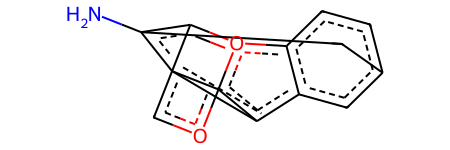

In [53]:
vis.mol_from_graphs(example_2_mod[0][0], example_2_mod[0][1])

In [17]:
mols = [vis.mol_from_graphs(samples[i][0], samples[i][1]) for i in range(len(samples))]
    
valid_mols = [mol for mol in mols if is_valid_molecule(mol)]
# remove duplicates
valid_mols = list(set(valid_mols))

Sanitization error: Explicit valence for atom # 7 N, 5, is greater than permitted
Sanitization error: Explicit valence for atom # 12 O, 3, is greater than permitted
Sanitization error: Explicit valence for atom # 8 O, 4, is greater than permitted
Sanitization error: Explicit valence for atom # 2 C, 5, is greater than permitted
Sanitization error: Explicit valence for atom # 13 C, 6, is greater than permitted
Sanitization error: Explicit valence for atom # 10 O, 3, is greater than permitted
Sanitization error: Explicit valence for atom # 9 C, 7, is greater than permitted
Sanitization error: Explicit valence for atom # 10 O, 4, is greater than permitted
Sanitization error: Explicit valence for atom # 9 C, 6, is greater than permitted


[13:10:19] Can't kekulize mol.  Unkekulized atoms: 1 2 4 6 7 8 11 12 13
[13:10:19] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 8 9 10 12
[13:10:19] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10
[13:10:19] Can't kekulize mol.  Unkekulized atoms: 1 4 5 7 8 12 13
[13:10:19] Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 5 6 7 8 10
[13:10:19] Can't kekulize mol.  Unkekulized atoms: 5 9 11 12 13
[13:10:19] Can't kekulize mol.  Unkekulized atoms: 0 5 6 8 13
[13:10:19] Can't kekulize mol.  Unkekulized atoms: 4 5 6 10 11
[13:10:19] Can't kekulize mol.  Unkekulized atoms: 1 2 4 6 7 8 10 12 13
[13:10:19] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 7 9 10 11
[13:10:19] Can't kekulize mol.  Unkekulized atoms: 1 2 4 9 10
[13:10:19] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 7 8 9 10
[13:10:19] Explicit valence for atom # 7 N, 5, is greater than permitted
[13:10:19] Explicit valence for atom # 12 O, 3, is greater than permitted
[13:10:19] Can't kekulize mol.  Unkekul

In [18]:
# compute tanimoto similarity between the generated samples and the test molecule
from rdkit.Chem import AllChem, DataStructs

mol_footprint = AllChem.GetMorganFingerprintAsBitVect(mol, 1, useChirality=True)
sample_footprints = [AllChem.GetMorganFingerprintAsBitVect(s, 1, useChirality=True) for s in valid_mols]

similarities = [DataStructs.TanimotoSimilarity(mol_footprint, sample_footprint) for sample_footprint in sample_footprints]
max(similarities)

0.4444444444444444

In [14]:
from analysis.visualization import MolecularVisualization
from datasets.moses_dataset import MOSESinfos, MOSESDataModule
from hydra import compose, initialize
from omegaconf import OmegaConf
from rdkit.Chem import SanitizeFlags
from rdkit import Chem

with initialize(version_base=None, config_path="configs"):
    cfg = compose(config_name="config")

datamodule = MOSESDataModule(cfg=cfg)
#datamodule.prepare_data()
infos = MOSESinfos(datamodule=datamodule)
vis = MolecularVisualization(remove_h=True, dataset_infos=infos)

mols = [vis.mol_from_graphs(samples[i][0], samples[i][1]) for i in range(len(samples))]
def is_valid_molecule(mol):
    """Check if a given RDKit molecule object is valid."""
    if mol is None:
        return False

    try:
        # Attempt to sanitize the molecule without kekulization
        Chem.SanitizeMol(mol, sanitizeOps=SanitizeFlags.SANITIZE_ALL ^ SanitizeFlags.SANITIZE_KEKULIZE)
        
        # Optionally, try to kekulize separately to identify issues
        try:
            Chem.Kekulize(mol)
        except Chem.KekulizeException:
            print("Warning: Molecule could not be kekulized, but will be considered valid.")

        # Additional checks
        if mol.GetNumAtoms() == 0:
            return False

        return True
    except (ValueError, Chem.rdchem.KekulizeException) as e:
        print(f"Sanitization error: {e}")
        return False
    
valid_mols = [mol for mol in mols if is_valid_molecule(mol)]
# remove duplicates
valid_mols = list(set(valid_mols))

Sanitization error: Explicit valence for atom # 8 C, 6, is greater than permitted
Sanitization error: Explicit valence for atom # 12 C, 5, is greater than permitted
Sanitization error: Explicit valence for atom # 12 C, 5, is greater than permitted
Sanitization error: Explicit valence for atom # 13 C, 5, is greater than permitted
Sanitization error: Explicit valence for atom # 13 C, 7, is greater than permitted


[20:51:10] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8 9 10 12 13
[20:51:10] Can't kekulize mol.  Unkekulized atoms: 3 6 7 8 9
[20:51:10] Explicit valence for atom # 8 C, 6, is greater than permitted
[20:51:10] Can't kekulize mol.  Unkekulized atoms: 2 4 7 12 13
[20:51:10] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 6 8 9 11 12
[20:51:10] Can't kekulize mol.  Unkekulized atoms: 3 6 8 9 12
[20:51:10] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 9 10 13
[20:51:10] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 10 12 13
[20:51:10] Can't kekulize mol.  Unkekulized atoms: 3 4 8 9 12
[20:51:10] Can't kekulize mol.  Unkekulized atoms: 0 3 8 9 13
[20:51:10] Can't kekulize mol.  Unkekulized atoms: 0 2 3 8 10 11 12
[20:51:10] Can't kekulize mol.  Unkekulized atoms: 2 3 4 6 7 9 11 12 13
[20:51:10] Can't kekulize mol.  Unkekulized atoms: 1 2 3 6 7 8 9 10 12
[20:51:10] Can't kekulize mol.  Unkekulized atoms: 1 3 13
[20:51:10] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3

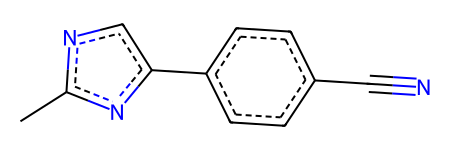

In [122]:
valid_mols[3]

In [123]:
smile = Chem.MolToSmiles(valid_mols[3])
smile

'Cc1ncc(-c2ccc(C#N)cc2)n1'

<Axes: >

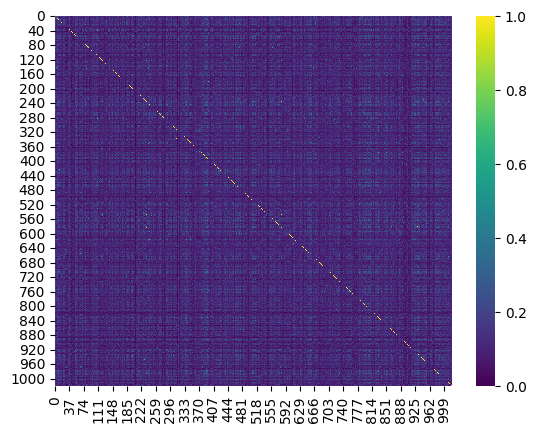

In [19]:
# compare tanimoto similarity between generated samples
from rdkit.Chem import AllChem
from rdkit import DataStructs

fps = [AllChem.GetMorganFingerprintAsBitVect(mol, 2) for mol in valid_mols]
similarity = [[DataStructs.TanimotoSimilarity(fp1, fp2) for fp2 in fps] for fp1 in fps]
# plot similarity matrix
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(similarity, cmap="viridis")
#plt.show()

In [24]:
# count how many molecules have another molecule with similarity > 0.8, excluding self-similarity
count = 0
temp = similarity
# set diagonal to 0
for i in range(len(temp)):
    temp[i][i] = 0
for i in range(len(temp)):
    if max(temp[i]) >= 0.7:
        count += 1
count/len(similarity)

0.06771344455348381

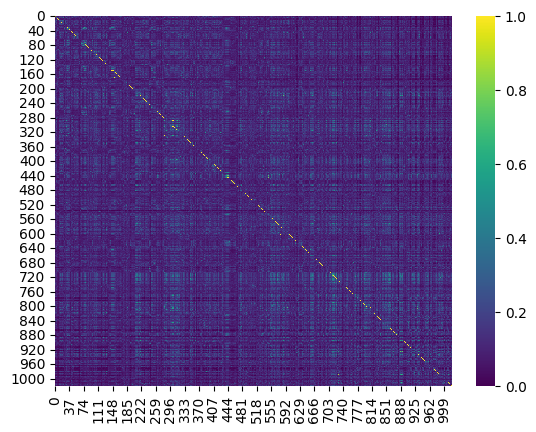

In [36]:
# group molecules by properties by molecular weight
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors

def get_molecular_weight(mol):
    return Descriptors.MolWt(mol)

# sort by ring count
valid_mols.sort(key=get_molecular_weight)
# plot similarity matrix withing ring count groups
fps = [AllChem.GetMorganFingerprintAsBitVect(mol, 2) for mol in valid_mols]
similarity = [[DataStructs.TanimotoSimilarity(fp1, fp2) for fp2 in fps] for fp1 in fps]
sns.heatmap(similarity, cmap="viridis")
plt.show()

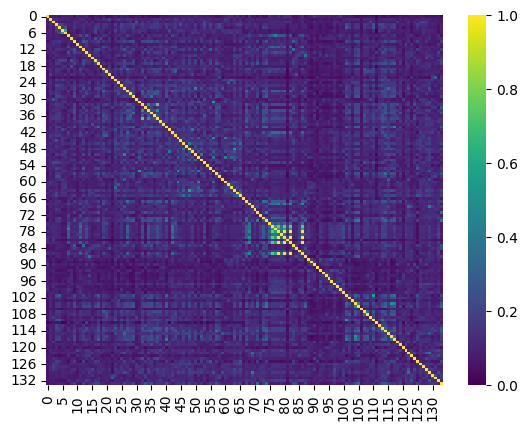

In [59]:
# select molecules with molecular weight between 200 and 300
sel_mols = [mol for mol in valid_mols if 189 <= get_molecular_weight(mol) <= 190]
# plot similarity matrix
fps = [AllChem.GetMorganFingerprintAsBitVect(mol, 2) for mol in sel_mols]
similarity = [[DataStructs.TanimotoSimilarity(fp1, fp2) for fp2 in fps] for fp1 in fps]
sns.heatmap(similarity, cmap="viridis")
plt.show()

In [244]:
count = 0
temp = similarity
# set diagonal to 0
for i in range(len(temp)):
    temp[i][i] = 0
for i in range(len(temp)):
    if max(temp[i]) >= 0.5:
        count += 1
count/len(similarity)

0.5084745762711864

In [245]:
def count_atoms(mol):
    """Count the number of each type of atom in a molecule."""
    atom_counts = {"C": 0, "O": 0, "H": 0, "N" : 0}
    for atom in mol.GetAtoms():
        element = atom.GetSymbol()
        if element in atom_counts:
            atom_counts[element] += 1
    return atom_counts

def has_exact_atom_counts(atom_counts, required_counts):
    """Check if the molecule has the exact required number of specific atoms."""
    for element, count in required_counts.items():
        if atom_counts.get(element, 0) != count:
            return False
    return True

def filter_molecules_by_exact_atom_counts(smiles_list, required_counts):
    """Filter molecules based on the exact counts of specific atoms."""
    valid_mols = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            atom_counts = count_atoms(mol)
            if has_exact_atom_counts(atom_counts, required_counts):
                valid_mols.append(mol)
    return valid_mols

[15:06:54] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 13
[15:06:54] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
[15:06:54] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 13
[15:06:54] Can't kekulize mol.  Unkekulized atoms: 5 6 7 10 11
[15:06:54] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[15:06:54] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11 12 13
[15:06:54] Can't kekulize mol.  Unkekulized atoms: 2 3 5 6 7
[15:06:54] Can't kekulize mol.  Unkekulized atoms: 7 8 9 11 12
[15:06:54] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[15:06:54] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9 10 11 12 13
[15:06:54] non-ring atom 0 marked aromatic
[15:06:54] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[15:06:54] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[15:06:54] non-ring atom 0 marked aromatic
[15:06:54] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 13
[15:06:54] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12

163


<Axes: >

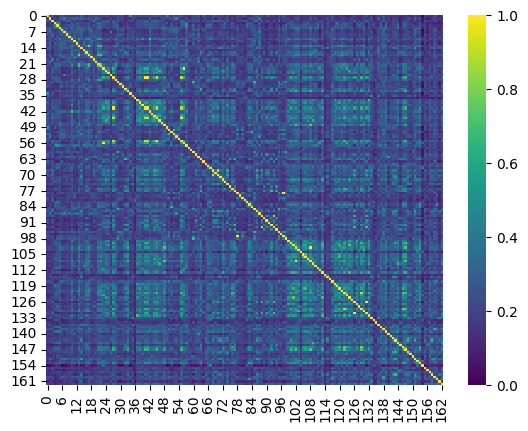

In [269]:
# select all molecules with specific substructure
from rdkit.Chem import rdFMCS
from rdkit.Chem import Draw

# find molecules that contain specific counts of atoms
counts = {"C": 11, "N": 2, "O" : 1}
sub_mols = filter_molecules_by_exact_atom_counts([Chem.MolToSmiles(mol) for mol in valid_mols], counts)
# compute similarity matrix for molecules with substructure and logP in range
#sub_mols = [mol for mol in sub_mols if 0.0 <= Descriptors.MolLogP(mol) <= 1.0]
print(len(sub_mols))
fps = [AllChem.GetMorganFingerprintAsBitVect(mol, radius=1, useChirality=True) for mol in sub_mols]
similarity = [[DataStructs.TanimotoSimilarity(fp1, fp2) for fp2 in fps] for fp1 in fps]
sns.heatmap(similarity, cmap="viridis")

In [275]:
count = 0
temp = similarity
# set diagonal to 0
for i in range(len(temp)):
    temp[i][i] = 0
for i in range(len(temp)):
    if max(temp[i]) >= 0.7:
        count += 1
count/len(similarity)

0.22699386503067484

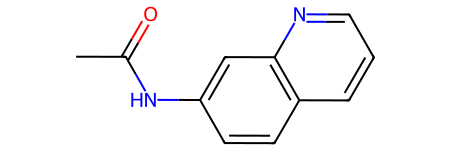

In [273]:
# show example of two similar molecules
mol1 = sub_mols[10]
import torch
# get molecule that has large tanimoto similarity
idxs = torch.tensor(similarity[10]) >= 0.7
#sub_mols[idxs[5]]
#mol1
sub_mols[10]
#sub_mols[16]

In [280]:
# save molecules to file
from rdkit.Chem import SDWriter
writer = SDWriter("molecules.sdf")
for mol in valid_mols:
    writer.write(mol)

[17:59:04] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 7 10 11


KekulizeException: Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 7 10 11

/home/kkladny/conformal_prediction_generative_models/DiGress/src


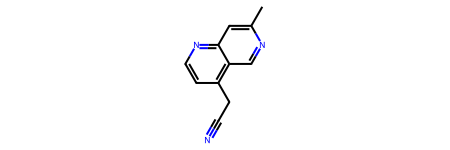

In [294]:
from rdkit.Chem import SanitizeMol

def write_molecules_to_sdf(molecules, filename):
    writer = SDWriter(filename)
    for mol in molecules:
        if mol is not None:
            try:
                # Attempt to sanitize the molecule without kekulization
                SanitizeMol(mol, sanitizeOps=SanitizeFlags.SANITIZE_ALL ^ SanitizeFlags.SANITIZE_KEKULIZE)
                writer.write(mol)
            except Exception as e:
                print(f"Skipping molecule due to sanitization error: {e}")
    writer.close()

#write_molecules_to_sdf(valid_mols, "valid_mols.sdf")
# load molecules from file
from rdkit.Chem import SDMolSupplier
print(os.getcwd())
supplier = SDMolSupplier("valid_mols.sdf")
mols = [mol for mol in supplier if mol is not None]
mols[8]